In [178]:
from typing import List, Dict, Any, Literal, Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI 
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.types import interrupt

In [179]:
class State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [ ]:
@tool
def ask_more_details(query: str) -> str:
  """
    Peça por mais informações para o usuário
  """
  print(f"ASK_MORE_DETAILS -> {query}")
  human_response = interrupt({"query": query})
  return human_response["data"]

tools = [ask_more_details]
tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)

In [181]:
llm_receptionist = ChatOpenAI(model="gpt-4o-mini")

receptionist_prompt = ChatPromptTemplate.from_messages([
  ("system", "Você é um assistente de compras online, responsavel por atender o usuário, perguntando o que ele deseja comprar."),
  MessagesPlaceholder("messages")
])

def receptionist(state: State):
  print("RECEPTIONIST")
  message = (receptionist_prompt | llm_receptionist.bind_tools(tools)).invoke(state["messages"])
  assert len(message.tool_calls) <= 1
  return {"messages": [message]}

graph_builder.add_node("receptionist", receptionist)

In [182]:
llm_analyst = ChatOpenAI(model="gpt-4o-mini")

analyst_prompt = ChatPromptTemplate.from_messages([
  ("system", "Você é um assistente de compras online, responsavel analisar produtos e selecionar os mais relevantes de acordo com os dados recebidos."),
  MessagesPlaceholder("messages")
])

def analyst(state: State):
  print("ANALYST")
  return {"messages": [llm_analyst.invoke(state["messages"])]}

graph_builder.add_node("analyst", receptionist)

In [183]:
llm_product_reviewer = ChatOpenAI(model="gpt-4o-mini")

product_reviewer_prompt = ChatPromptTemplate.from_messages([
  ("system", "Você é um assistente de compras online, responsavel por comparar produtos pré-selecionados afim de ajudar o usuário na sua decisão de compra."),
  MessagesPlaceholder("messages")
])

def product_reviewer(state: State):
  print("PRODUCT_REVIEWER")
  return {"messages": [llm_product_reviewer.invoke(state["messages"])]}

graph_builder.add_node("product_reviewer", receptionist)

In [184]:
def need_more_details(state: State) -> Literal["tools", "analyst"]:
  """Define se precisa pedir mais detalhes para o usuário"""
  print("NEED_MORE_DETAILS")
  last_message = state["messages"][-1]
  return "tools" if last_message.tool_calls else "analyst"


graph_builder.add_edge(START, "receptionist")
graph_builder.add_conditional_edges(
  "receptionist",
  need_more_details,
)
graph_builder.add_edge("tools", "receptionist")
graph_builder.add_edge("analyst",  "product_reviewer")
graph_builder.add_edge("product_reviewer", END)

In [185]:
graph = graph_builder.compile()

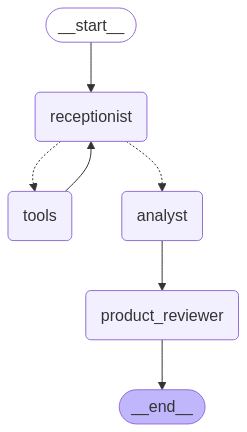

In [186]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  # This requires some extra dependencies and is optional
  pass

In [ ]:
def stream_graph_updates(user_input: str):
  for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
    for value in event.values():
      print("Assistant:", value["messages"][-1].content)


while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break

    stream_graph_updates(user_input)
  except:
    # fallback if input() is not available
    user_input = "What do you know about LangGraph?"
    print("User: " + user_input)
    stream_graph_updates(user_input)
    break

RECEPTIONIST
NEED_MORE_DETAILS
Assistant: 
ASK_MORE_DETAILS -> Que tipo de tênis você está procurando? (ex: esportivo, casual, para correr, etc.)
User: What do you know about LangGraph?
RECEPTIONIST
NEED_MORE_DETAILS
Assistant: LangGraph is a platform that often combines elements of language processing and graph databases to facilitate various applications, including natural language understanding and relationship mapping. It allows users to leverage language models and graph structures to analyze, visualize, and extract insights from textual data.

The details and capabilities of LangGraph can vary depending on its implementations and updates. If you are looking for specific functionalities or use cases, please let me know!
RECEPTIONIST
Assistant: 
RECEPTIONIST


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_fV87rTdQmItZuwCyXA4pF2NN", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}